<a href="https://colab.research.google.com/github/sccn/sound2meg/blob/main/wav2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
pip install fairseq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import re
import numpy as np
#import torch
import os
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import librosa
import fairseq
import torch
import pandas as pd
import wave
import pydub
import librosa
from resampy import resample

In [50]:
def segment_audio(audio_file):
    audio_input, sample_rate = librosa.load(audio_file)
    audio_segment = sample_rate * 3
    segments = []
    if len(audio_input) >= audio_segment * 2:
      check = True
      while check:
          segments.append(audio_input[:audio_segment])
          audio_input = audio_input[audio_segment:]
          if len(audio_input) < audio_segment:
              check = False
    else:
      segments.append(audio_input[:audio_segment])
    return segments, sample_rate

# return first 3 second segment in audio file
def three_second(audio_file):
    audio_input, sample_rate = librosa.load(audio_file)
    mono_audio = librosa.to_mono(audio_input)

    audio_segment = sample_rate * 3
    segment = mono_audio[:audio_segment]
    data = resample(segment, sample_rate, 16000)
    return data, sample_rate


def read_event(tsv_path):
    event = pd.read_csv("sub-A2014_task-auditory_events.tsv", sep = '\t')
    event = event[event['type'] == 'Sound']

    batch["onset"], batch["sample"], batch["audio_file"] = event['onset'], event['sample'], event['audio_file']
    
    return batch


def prepare_dataset(batch, feature_extractor):
    for audio in audio_file_directory:
        if audio in batch["audio_file"]:
            segment, sample_rate = three_second(audio)
            #segment, sample_rate = segment_audio(audio)
            
            feature_extractor = prepare_feature_extractor(sample_rate)
            batch["input_values"] = feature_extractor(segment, return_tensors="pt").input_values

    return batch

def prepare_model(model_path):
    #model = Wav2Vec2ForCTC.from_pretrained(model_path)
    model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean", 
)
    return model

def prepare_feature_extractor(sampling_rate):
    # check that all files have the correct sampling rate
    #feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=sampling_rate, padding_value=0.0, do_normalize=True, return_attention_mask=True)
    feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
    return feature_extractor


def check_wav_hz(filepath):
    with wave.open(filepath, 'r') as wav_file:
        # Get the sample rate (in Hz)
        sample_rate = wav_file.getframerate()
        return sample_rate

In [8]:
check_wav_hz('EQ_Ramp_Int2_Int1LPF001.wav')

44100

In [24]:
model_path = "facebook/wav2vec2-large-xlsr-53"
model = prepare_model(model_path)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_q.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

In [25]:
feature = prepare_feature_extractor(16000)

In [26]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

In [27]:
feature

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [51]:
model_path = "facebook/wav2vec2-large-xlsr-53"
audio_path = "/content/audio"

model = prepare_model(model_path)
files = os.listdir(audio_path)

# for wav_file in files:
#     count = 0
#     name = re.search('(\d+)\.', wav_file).group().replace('.', '_')

#     audio = os.path.join(audio_path, wav_file)

#     audio_input, sample_rate = segment_audio(audio)
#     feature_extractor = prepare_feature_extractor(sample_rate)

#     if len(audio_input) > 1:
#         for audio in audio_input:
#             input_values = feature_extractor(audio, return_tensors="pt").input_values
#             logits = model(input_values).logits

#             output = logits.detach().numpy()
#             np.save(f'{name}{count}.npy', output)

#             count += 1
#     else:
#         input_values = feature_extractor(audio_input, return_tensors="pt").input_values
#         logits = model(input_values).logits

#         output = logits.detach().numpy()
#         np.save(f'{name}.npy', output)

# Only first three second segements
for wav_file in files:
    name = re.search('(\d+)\.', wav_file).group().replace('.', '')

    audio = os.path.join(audio_path, wav_file)

    audio_input, sample_rate = three_second(audio)
    #audio_input, sample_rate = librosa.load(audio)
    print(audio_input.shape)
    feature_extractor = prepare_feature_extractor(sample_rate)

    input_values = feature_extractor(audio_input, return_tensors="pt").input_values
    print(input_values.shape)

    logits = model(input_values).logits
    print(logits.shape)
    break
    output = logits.detach().numpy()
    np.save(os.path.join('/content/Embedding/MyDrive/Embedding', f'{name}.npy'), output)



Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_q.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

(48000,)
torch.Size([1, 48000])
torch.Size([1, 149, 32])


In [49]:
import re
import numpy as np
import torch
import os
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import librosa
import fairseq
import torch
import pandas as pd
from scipy import interpolate


model_path = "facebook/wav2vec2-large-xlsr-53"
audio_path = "/content/audio"

model = prepare_model(model_path)
files = os.listdir(audio_path)

# for wav_file in files:
#     count = 0
#     name = re.search('(\d+)\.', wav_file).group().replace('.', '_')

#     audio = os.path.join(audio_path, wav_file)

#     audio_input, sample_rate = segment_audio(audio)
#     feature_extractor = prepare_feature_extractor(sample_rate)

#     if len(audio_input) > 1:
#         for audio in audio_input:
#             input_values = feature_extractor(audio, return_tensors="pt").input_values
#             logits = model(input_values).logits

#             output = logits.detach().numpy()
#             np.save(f'{name}{count}.npy', output)

#             count += 1
#     else:
#         input_values = feature_extractor(audio_input, return_tensors="pt").input_values
#         logits = model(input_values).logits

#         output = logits.detach().numpy()
#         np.save(f'{name}.npy', output)

# Only first three second segements
for wav_file in files:
    #dt = 34200 * 3
    dt = 16000 * 3

    name = re.search('(\d+)\.', wav_file).group().replace('.', '')

    audio = os.path.join(audio_path, wav_file)

    audio_input, sample_rate = three_second(audio)

    Told = np.linspace(audio_input.min(),audio_input.max(),len(audio_input))
    F = interpolate.interp1d(Told,audio_input,fill_value='extrapolate') 
    Tnew = np.linspace(audio_input.min(), audio_input.max(), dt)
    audio_resampled = F(Tnew)

    feature_extractor = prepare_feature_extractor(sample_rate)

    input_values = feature_extractor(audio_resampled, return_tensors="pt").input_values
    print(input_values.shape)
    logits = model(input_values).logits
    print(logits.shape)
    break
    output = logits.detach().numpy()
    np.save(os.path.join('/content/Embedding/MyDrive/Embedding', f'{name}.npy'), output)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_q.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

torch.Size([1, 48000])
torch.Size([1, 149, 32])


In [ ]:
import matplotlib.pyplot as plt

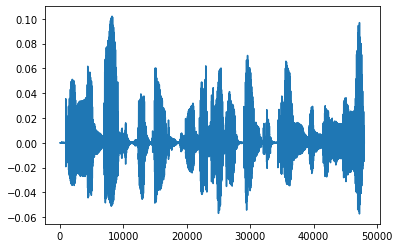

In [ ]:
plt.plot(audio_resampled)

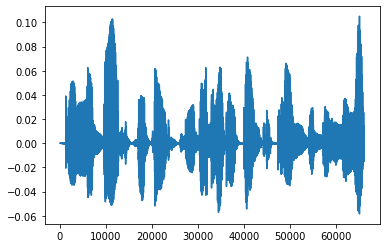

In [ ]:
plt.plot(audio_input)

In [ ]:
from scipy.interpolate import interp1d  

dt = 16000 * 3
Told = np.linspace(audio_input.min(),audio_input.max(),len(audio_input))
print(audio_input.shape)
print(Told.shape)
F = interp1d(Told,audio_input,fill_value='extrapolate') 
Tnew = np.linspace(audio_input.min(), audio_input.max(), dt)
audio_resampled = F(Tnew)

(66150,)
(66150,)


In [ ]:
audio_resampled.shape

(48000,)

In [43]:
audio, sr = librosa.load("/content/audio/EQ_Ramp_Int2_Int1LPF001.wav")
mono_audio = librosa.to_mono(audio)
print(mono_audio.shape)

(108623,)


In [38]:
audio = pydub.AudioSegment.from_file("/content/audio/EQ_Ramp_Int2_Int1LPF001.wav")
channels = audio.channels

In [41]:
audio.shape

AttributeError: ignored